In [1]:
!pip install -q transformers datasets evaluate accelerate gluonts ujson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/

In [2]:
!pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from functools import lru_cache, partial
import pandas as pd
import numpy as np
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.time_feature import get_lags_for_frequency
from pandas.core.arrays.period import period_array
from transformers import InformerConfig, InformerForPrediction
from transformers import PretrainedConfig
from typing import Optional

from gluonts.transform.sampler import InstanceSampler


from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

from accelerate import Accelerator
from torch.optim import AdamW

from evaluate import load
from gluonts.time_feature import get_seasonality
from datetime import datetime

In [ ]:
tc_dataset = load_dataset("shaddie/thrust_curves_dataset")

In [5]:
# Specify train/test split fraction
train_fraction = 0.9  # 80% for training, 20% for testing

# Split the original training set into new train/test sets
split_dataset = tc_dataset["train"].train_test_split(train_size=train_fraction, seed=42)

In [ ]:
split_dataset

In [7]:
def find_pad_max(dataset):
    l=len(dataset)
    m = 0
    for r in range(l):
        # real = tc_dataset[split][r]['feat_dynamic_real']
        target = dataset[r]['target']
        if m < len(target):
            m = len(target)

    return m


def pad_data(data, m, split):
    l=len(data)
    tc = []
    for r in range(l):
        real = data[r]['feat_dynamic_real']
        target = data[r]['target']
        rlen = len(real)
        pad = [0 for _ in range(m-rlen)]
        # target = tc_dataset['train'][r]['target']
        real = real + pad
        target = target + pad
        tc.append({
            'start': data[r]['start'],
            'target': target,
            'feat_static_cat': data[r]['feat_static_cat'],
            'feat_dynamic_real': real,
            'item_id': data[r]['item_id']
                }
            )

    return tc

In [8]:
from datasets import Dataset
m1 = find_pad_max(split_dataset["train"])
m2 = find_pad_max(split_dataset["test"])
m = max(m1,m2)
print(m)

61


In [9]:
train_data = pad_data(split_dataset["train"], m=m, split="train")
test_data = pad_data(split_dataset["test"], m=m, split="test")

In [10]:
train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)

In [11]:
train_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 239
})

In [12]:
test_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 27
})

In [13]:
freq = "1W"
prediction_length = 8

# assert len(train_example["target"]) + prediction_length == len(
#     dataset["validation"][0]["target"]
# )

In [14]:
train_example = train_dataset[0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

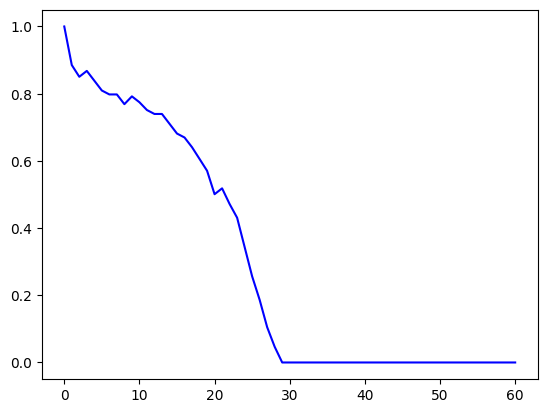

In [15]:
num_of_samples = 150

figure, axes = plt.subplots()
axes.plot(
          # train_example["feat_dynamic_real"][-num_of_samples:],
          train_example["target"][-num_of_samples:],
          color="blue")

plt.show()

In [16]:
@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [17]:
train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [18]:
num_of_variates = len(test_dataset) # group according to the smaller test dataset size

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates
    # max_target_dim=num_of_variates,
    # num_test_dates=len(test_dataset),
    # num_test_dates=None, # len(test_dataset),
    # num_of_variates=num  # number of rolling test windows
)

multi_variate_train_dataset = train_grouper(train_dataset)
multi_variate_test_dataset = test_grouper(test_dataset)

In [19]:
multi_variate_train_example = multi_variate_train_dataset[0]
print(
    f"multi_variate_train_example['target'].shape = {multi_variate_train_example['target'].shape}"
)

multi_variate_train_example['target'].shape = (27, 99)


In [20]:
multi_variate_test_example = multi_variate_test_dataset[0]
print(
    f"multi_variate_test_example['target'].shape = {multi_variate_test_example['target'].shape}"
)

multi_variate_test_example['target'].shape = (27, 95)


In [21]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function day_of_month at 0x7a36a3d3e0c0>, <function week_of_year at 0x7a36a3d3e480>]


Look back certain time range for each time step, as additional features "lags_sequence"

In [22]:
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 8, 12, 51, 52, 53, 103, 104, 105, 155, 156, 157]


In [23]:
timestamp = pd.Period("2025-01-01 01:00:01", freq=freq)
timestamp_as_index = pd.PeriodIndex(data=period_array([timestamp]))
additional_features = [
    (time_feature.__name__, time_feature(timestamp_as_index))
    for time_feature in time_features
]
print(dict(additional_features))

{'day_of_month': array([-0.36666667]), 'week_of_year': array([-0.5])}


In [24]:
model = None

In [25]:
from transformers import InformerForPrediction

In [26]:
try:
    model = InformerForPrediction.from_pretrained("shaddie/rocketpill_thrustcurve_informer_model")
    print(f"successfully loaded model from hugging face with Config {model.config}")
except:
    print(f"An exception occurred when loading model from HF; initializing new model...")
    config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 24 * 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,
    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
    )

    model = InformerForPrediction(config)
    print(f"New model initialized with config {model.config}")

config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

successfully loaded model from hugging face with Config InformerConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "architectures": [
    "InformerForPrediction"
  ],
  "attention_dropout": 0.1,
  "attention_type": "prob",
  "cardinality": [
    0
  ],
  "context_length": 16,
  "d_model": 64,
  "decoder_attention_heads": 2,
  "decoder_ffn_dim": 32,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 4,
  "distil": true,
  "distribution_output": "student_t",
  "dropout": 0.1,
  "embedding_dimension": [
    0
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 32,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 6,
  "feature_size": 111,
  "init_std": 0.02,
  "input_size": 27,
  "is_encoder_decoder": true,
  "lags_sequence": [
    1,
    168
  ],
  "loss": "nll",
  "model_type": "informer",
  "num_dynamic_real_features": 0,
  "num_parallel_samples": 100,
  "num_static_categorical_features": 0,
  "num_static_real_features": 0,
  "num_time_features": 3,
  "prediction

In [27]:
model.config.distribution_output

'student_t'

In [28]:
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [29]:
def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [30]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from all the possible transformed time series, 1 in our case)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [31]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
        num_batches_per_epoch=num_batches_per_epoch,
    )


In [32]:
config = model.config

In [33]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)


In [34]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 184, 3]) torch.FloatTensor
past_values torch.Size([256, 184, 27]) torch.FloatTensor
past_observed_mask torch.Size([256, 184, 27]) torch.FloatTensor
future_time_features torch.Size([256, 8, 3]) torch.FloatTensor
future_values torch.Size([256, 8, 27]) torch.FloatTensor
future_observed_mask torch.Size([256, 8, 27]) torch.FloatTensor


In [35]:
batch = next(iter(test_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([1, 184, 3]) torch.FloatTensor
past_values torch.Size([1, 184, 27]) torch.FloatTensor
past_observed_mask torch.Size([1, 184, 27]) torch.FloatTensor
future_time_features torch.Size([1, 8, 3]) torch.FloatTensor


In [39]:
def compute_mase_smape(forecasts):

  mase_metric = load("evaluate-metric/mase")
  smape_metric = load("evaluate-metric/smape")

  forecast_median = np.median(forecasts, 1).squeeze(0).T

  mase_metrics = []
  smape_metrics = []

  for item_id, ts in enumerate(test_dataset):
      training_data = ts["target"][:-prediction_length]
      ground_truth = ts["target"][-prediction_length:]
      mase = mase_metric.compute(
          predictions=forecast_median[item_id],
          references=np.array(ground_truth),
          training=np.array(training_data),
          periodicity=get_seasonality(freq),
      )
      mase_metrics.append(mase["mase"])

      smape = smape_metric.compute(
          predictions=forecast_median[item_id],
          references=np.array(ground_truth),
      )
      smape_metrics.append(smape["smape"])

  return np.mean(mase_metrics), np.mean(smape_metrics)

In [41]:
def test():
  model.eval()
  forecasts_ = []
  test_progress_bar = tqdm(test_dataloader, desc=f"Epoch ")
      # for data in tqdm(train_dataloader,  desc=f"Epoch {epoch+1}"):
  for idx, batch in enumerate(test_progress_bar):
    # for k, v in batch.items():
    #   print(k, v.shape, v.type())
    # print(f'past_observed_mask {batch["past_observed_mask"].to(device).repeat(1,1, 3).shape}')
    # print(f'future_time_features {batch["future_time_features"].to(device).shape}')
    outputs = model.generate(
      static_categorical_features=batch["static_categorical_features"].to(device)
      if config.num_static_categorical_features > 0
      else None,
      static_real_features=batch["static_real_features"].to(device)
      if config.num_static_real_features > 0
      else None,
      past_time_features=batch["past_time_features"].to(device),
      past_values=batch["past_values"].to(device),
      future_time_features=batch["future_time_features"].to(device),
      past_observed_mask=batch["past_observed_mask"].to(device),
    )
  forecasts_.append(outputs.sequences.cpu().numpy())
  forecasts = np.vstack(forecasts_)

  mase, smape = compute_mase_smape(forecasts=forecasts)

  # print(f'mase: {mase} & smape: {smape}')

  return mase, smape


In [ ]:
from tqdm import tqdm
epochs = 100
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    total_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} total_loss {total_loss} ")
    # for data in tqdm(train_dataloader,  desc=f"Epoch {epoch+1}"):
    for idx, batch in enumerate(progress_bar):
        # print(f'idx: {idx}')
        # for k, v in batch.items():
        #     print(k, v.shape, v.type())
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss
        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 200 == 0:
            mase, smape = test()
            print(f'Epoch {epoch} mape: {mase} & smape: {smape}  with loss: {loss.item()}')

Epoch 1/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-121]
Epoch : 1it [00:00, 10.54it/s]
Epoch 1/100 total_loss 0.0 : 2it [00:01,  1.43it/s, loss=-93]

Epoch 0 mape: 3.577911411069254 & smape: 1.9999997711687385  with loss: -121.0096664428711


Epoch 1/100 total_loss 0.0 : 100it [00:15,  6.41it/s, loss=-213]
Epoch 2/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-226]
Epoch : 1it [00:00, 10.41it/s]
Epoch 2/100 total_loss 0.0 : 2it [00:01,  1.54it/s, loss=-227]

Epoch 1 mape: 3.1106627831477516 & smape: 1.9999997355596915  with loss: -226.26834106445312


Epoch 2/100 total_loss 0.0 : 100it [00:15,  6.53it/s, loss=-223]
Epoch 3/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-224]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  6.85it/s]
Epoch 3/100 total_loss 0.0 : 1it [00:01,  1.60s/it, loss=-225]

Epoch 2 mape: 2.9959518937605387 & smape: 1.9999997172001553  with loss: -223.87684631347656


Epoch 3/100 total_loss 0.0 : 100it [00:15,  6.32it/s, loss=-223]
Epoch 4/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-229]
Epoch : 1it [00:00, 10.36it/s]
Epoch 4/100 total_loss 0.0 : 2it [00:01,  1.55it/s, loss=-233]

Epoch 3 mape: 3.0508902100686175 & smape: 1.999999722374408  with loss: -229.04269409179688


Epoch 4/100 total_loss 0.0 : 100it [00:15,  6.48it/s, loss=-225]
Epoch 5/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-208]
Epoch : 1it [00:00, 10.08it/s]
Epoch 5/100 total_loss 0.0 : 2it [00:01,  1.54it/s, loss=-221]

Epoch 4 mape: 3.007629146251214 & smape: 1.999999720739333  with loss: -207.7871551513672


Epoch 5/100 total_loss 0.0 : 100it [00:15,  6.43it/s, loss=-224]
Epoch 6/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-225]
Epoch : 1it [00:00, 10.66it/s]
Epoch 6/100 total_loss 0.0 : 2it [00:01,  1.52it/s, loss=-226]

Epoch 5 mape: 2.988946867129096 & smape: 1.999999715656042  with loss: -225.22608947753906


Epoch 6/100 total_loss 0.0 : 100it [00:15,  6.39it/s, loss=-225]
Epoch 7/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-222]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  7.20it/s]
Epoch 7/100 total_loss 0.0 : 2it [00:01,  1.30it/s, loss=-230]

Epoch 6 mape: 3.0142688711527663 & smape: 1.9999997128674731  with loss: -222.10385131835938


Epoch 7/100 total_loss 0.0 : 100it [00:15,  6.36it/s, loss=-225]
Epoch 8/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-210]
Epoch : 1it [00:00, 10.61it/s]
Epoch 8/100 total_loss 0.0 : 2it [00:01,  1.43it/s, loss=-213]

Epoch 7 mape: 3.0296874543692103 & smape: 1.999999721133946  with loss: -210.30821228027344


Epoch 8/100 total_loss 0.0 : 100it [00:15,  6.42it/s, loss=-226]
Epoch 9/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-224]
Epoch : 1it [00:00, 10.37it/s]
Epoch 9/100 total_loss 0.0 : 2it [00:01,  1.57it/s, loss=-228]

Epoch 8 mape: 2.99120895143361 & smape: 1.9999997113670003  with loss: -224.04644775390625


Epoch 9/100 total_loss 0.0 : 100it [00:15,  6.43it/s, loss=-226]
Epoch 10/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-224]
Epoch : 1it [00:00, 10.71it/s]
Epoch 10/100 total_loss 0.0 : 2it [00:01,  1.58it/s, loss=-228]

Epoch 9 mape: 3.0158650326540886 & smape: 1.9999997165493437  with loss: -224.0996856689453


Epoch 10/100 total_loss 0.0 : 100it [00:15,  6.44it/s, loss=-225]
Epoch 11/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-220]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  7.70it/s]
Epoch 11/100 total_loss 0.0 : 1it [00:01,  1.59s/it, loss=-222]

Epoch 10 mape: 3.0562489508446467 & smape: 1.9999997244719312  with loss: -220.1826171875


Epoch 11/100 total_loss 0.0 : 100it [00:16,  6.24it/s, loss=-227]
Epoch 12/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-246]
Epoch : 1it [00:00, 10.52it/s]
Epoch 12/100 total_loss 0.0 : 2it [00:01,  1.56it/s, loss=-233]

Epoch 11 mape: 3.106917498973934 & smape: 1.9999997362011512  with loss: -246.01809692382812


Epoch 12/100 total_loss 0.0 : 100it [00:15,  6.47it/s, loss=-226]
Epoch 13/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-234]
Epoch : 1it [00:00, 10.72it/s]
Epoch 13/100 total_loss 0.0 : 2it [00:01,  1.47it/s, loss=-232]

Epoch 12 mape: 3.1012812026583667 & smape: 1.9999997342086162  with loss: -234.49945068359375


Epoch 13/100 total_loss 0.0 : 100it [00:15,  6.41it/s, loss=-226]
Epoch 14/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-233]
Epoch : 1it [00:00, 10.22it/s]
Epoch 14/100 total_loss 0.0 : 2it [00:01,  1.55it/s, loss=-230]

Epoch 13 mape: 3.080949346547525 & smape: 1.999999730170393  with loss: -233.37525939941406


Epoch 14/100 total_loss 0.0 : 100it [00:15,  6.37it/s, loss=-226]
Epoch 15/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-218]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  7.31it/s]
Epoch 15/100 total_loss 0.0 : 2it [00:01,  1.38it/s, loss=-223]

Epoch 14 mape: 3.130004295173916 & smape: 1.9999997375090364  with loss: -218.0869140625


Epoch 15/100 total_loss 0.0 : 100it [00:15,  6.33it/s, loss=-227]
Epoch 16/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-232]
Epoch : 1it [00:00, 10.51it/s]
Epoch 16/100 total_loss 0.0 : 2it [00:01,  1.60it/s, loss=-232]

Epoch 15 mape: 3.1498505078405 & smape: 1.9999997414729735  with loss: -231.73568725585938


Epoch 16/100 total_loss 0.0 : 100it [00:15,  6.45it/s, loss=-227]
Epoch 17/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-217]
Epoch : 1it [00:00, 10.23it/s]
Epoch 17/100 total_loss 0.0 : 2it [00:01,  1.54it/s, loss=-222]

Epoch 16 mape: 3.170070206629703 & smape: 1.9999997481004956  with loss: -216.81613159179688


Epoch 17/100 total_loss 0.0 : 100it [00:15,  6.42it/s, loss=-224]
Epoch 18/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-229]
Epoch : 1it [00:00, 10.16it/s]
Epoch 18/100 total_loss 0.0 : 2it [00:01,  1.56it/s, loss=-231]

Epoch 17 mape: 3.1596007716029066 & smape: 1.9999997469564692  with loss: -228.68846130371094


Epoch 18/100 total_loss 0.0 : 100it [00:15,  6.39it/s, loss=-227]
Epoch 19/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-213]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  7.90it/s]
Epoch 19/100 total_loss 0.0 : 2it [00:01,  1.46it/s, loss=-225]

Epoch 18 mape: 3.176170102044049 & smape: 1.9999997497790412  with loss: -213.14974975585938


Epoch 19/100 total_loss 0.0 : 100it [00:15,  6.39it/s, loss=-226]
Epoch 20/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-219]
Epoch : 1it [00:00, 10.60it/s]
Epoch 20/100 total_loss 0.0 : 2it [00:01,  1.56it/s, loss=-223]

Epoch 19 mape: 3.1202016153694876 & smape: 1.9999997420980922  with loss: -218.99501037597656


Epoch 20/100 total_loss 0.0 : 100it [00:15,  6.37it/s, loss=-227]
Epoch 21/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-226]
Epoch : 1it [00:00, 10.01it/s]
Epoch 21/100 total_loss 0.0 : 2it [00:01,  1.56it/s, loss=-228]

Epoch 20 mape: 3.2023402700262773 & smape: 1.9999997535490608  with loss: -225.98318481445312


Epoch 21/100 total_loss 0.0 : 100it [00:15,  6.41it/s, loss=-228]
Epoch 22/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-225]
Epoch : 1it [00:00, 10.65it/s]
Epoch 22/100 total_loss 0.0 : 2it [00:01,  1.58it/s, loss=-226]

Epoch 21 mape: 3.2422980770068213 & smape: 1.9999997583212936  with loss: -225.09747314453125


Epoch 22/100 total_loss 0.0 : 100it [00:15,  6.34it/s, loss=-228]
Epoch 23/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-239]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  8.23it/s]
Epoch 23/100 total_loss 0.0 : 2it [00:01,  1.50it/s, loss=-240]

Epoch 22 mape: 3.1773116342324528 & smape: 1.999999752175253  with loss: -238.97402954101562


Epoch 23/100 total_loss 0.0 : 100it [00:15,  6.44it/s, loss=-228]
Epoch 24/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-230]
Epoch : 1it [00:00, 10.66it/s]
Epoch 24/100 total_loss 0.0 : 2it [00:01,  1.57it/s, loss=-235]

Epoch 23 mape: 3.2130763594135323 & smape: 1.9999997566916785  with loss: -230.44418334960938


Epoch 24/100 total_loss 0.0 : 100it [00:15,  6.48it/s, loss=-227]
Epoch 25/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-244]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  8.58it/s]
Epoch 25/100 total_loss 0.0 : 2it [00:01,  1.54it/s, loss=-236]

Epoch 24 mape: 3.1522714383767645 & smape: 1.9999997515042514  with loss: -244.1856689453125


Epoch 25/100 total_loss 0.0 : 100it [00:15,  6.47it/s, loss=-228]
Epoch 26/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-246]
Epoch : 1it [00:00, 10.50it/s]
Epoch 26/100 total_loss 0.0 : 2it [00:01,  1.57it/s, loss=-240]

Epoch 25 mape: 3.158266912134505 & smape: 1.999999752706093  with loss: -246.12936401367188


Epoch 26/100 total_loss 0.0 : 100it [00:15,  6.40it/s, loss=-227]
Epoch 27/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-218]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  7.56it/s]
Epoch 27/100 total_loss 0.0 : 2it [00:01,  1.42it/s, loss=-222]

Epoch 26 mape: 3.197703344960733 & smape: 1.9999997580882143  with loss: -217.78744506835938


Epoch 27/100 total_loss 0.0 : 100it [00:15,  6.43it/s, loss=-228]
Epoch 28/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-221]
Epoch : 1it [00:00, 10.05it/s]
Epoch 28/100 total_loss 0.0 : 2it [00:01,  1.54it/s, loss=-226]

Epoch 27 mape: 3.157982780931636 & smape: 1.999999753311542  with loss: -220.7361297607422


Epoch 28/100 total_loss 0.0 : 100it [00:15,  6.48it/s, loss=-226]
Epoch 29/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-231]
Epoch : 1it [00:00, 10.65it/s]
Epoch 29/100 total_loss 0.0 : 2it [00:01,  1.58it/s, loss=-231]

Epoch 28 mape: 3.150051151246722 & smape: 1.9999997555356044  with loss: -230.68533325195312


Epoch 29/100 total_loss 0.0 : 100it [00:15,  6.41it/s, loss=-227]
Epoch 30/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-227]
Epoch : 1it [00:00, 10.16it/s]
Epoch 30/100 total_loss 0.0 : 2it [00:01,  1.57it/s, loss=-226]

Epoch 29 mape: 3.1292164312141515 & smape: 1.9999997501966857  with loss: -227.1942138671875


Epoch 30/100 total_loss 0.0 : 100it [00:15,  6.38it/s, loss=-227]
Epoch 31/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-240]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  8.65it/s]
Epoch 31/100 total_loss 0.0 : 2it [00:01,  1.37it/s, loss=-232]

Epoch 30 mape: 3.140627244289293 & smape: 1.9999997528734812  with loss: -239.623046875


Epoch 31/100 total_loss 0.0 : 100it [00:15,  6.40it/s, loss=-228]
Epoch 32/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-228]
Epoch : 1it [00:00, 10.12it/s]
Epoch 32/100 total_loss 0.0 : 2it [00:01,  1.50it/s, loss=-227]

Epoch 31 mape: 3.13793827595448 & smape: 1.999999749742524  with loss: -227.74502563476562


Epoch 32/100 total_loss 0.0 : 100it [00:15,  6.44it/s, loss=-229]
Epoch 33/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-233]
Epoch : 1it [00:00, 10.41it/s]
Epoch 33/100 total_loss 0.0 : 2it [00:01,  1.49it/s, loss=-231]

Epoch 32 mape: 3.129885535349818 & smape: 1.9999997518520585  with loss: -233.03109741210938


Epoch 33/100 total_loss 0.0 : 100it [00:15,  6.46it/s, loss=-228]
Epoch 34/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-230]
Epoch : 1it [00:00, 10.25it/s]
Epoch 34/100 total_loss 0.0 : 2it [00:01,  1.55it/s, loss=-223]

Epoch 33 mape: 3.130909694658751 & smape: 1.9999997524457616  with loss: -230.03195190429688


Epoch 34/100 total_loss 0.0 : 100it [00:16,  6.22it/s, loss=-228]
Epoch 35/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-228]
Epoch : 1it [00:00, 10.14it/s]
Epoch 35/100 total_loss 0.0 : 2it [00:01,  1.54it/s, loss=-233]

Epoch 34 mape: 3.1751942318331876 & smape: 1.9999997557370401  with loss: -227.5210418701172


Epoch 35/100 total_loss 0.0 : 100it [00:15,  6.42it/s, loss=-228]
Epoch 36/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-219]
Epoch : 1it [00:00, 10.16it/s]
Epoch 36/100 total_loss 0.0 : 2it [00:01,  1.56it/s, loss=-227]

Epoch 35 mape: 3.137659669235911 & smape: 1.9999997505261504  with loss: -218.59393310546875


Epoch 36/100 total_loss 0.0 : 100it [00:15,  6.38it/s, loss=-228]
Epoch 37/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-233]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  9.56it/s]
Epoch 37/100 total_loss 0.0 : 2it [00:01,  1.29it/s, loss=-231]

Epoch 36 mape: 3.123351130531585 & smape: 1.9999997491338217  with loss: -233.3032684326172


Epoch 37/100 total_loss 0.0 : 100it [00:15,  6.31it/s, loss=-227]
Epoch 38/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-243]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  6.63it/s]
Epoch 38/100 total_loss 0.0 : 2it [00:02,  1.03it/s, loss=-237]

Epoch 37 mape: 3.1471744776724675 & smape: 1.9999997540162326  with loss: -242.64820861816406


Epoch 38/100 total_loss 0.0 : 100it [00:16,  6.07it/s, loss=-228]
Epoch 39/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-229]
Epoch : 1it [00:00, 10.40it/s]
Epoch 39/100 total_loss 0.0 : 2it [00:01,  1.53it/s, loss=-240]

Epoch 38 mape: 3.171762052390213 & smape: 1.9999997522060728  with loss: -228.97607421875


Epoch 39/100 total_loss 0.0 : 100it [00:15,  6.45it/s, loss=-227]
Epoch 40/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-228]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  9.60it/s]
Epoch 40/100 total_loss 0.0 : 2it [00:02,  1.15s/it, loss=-228]

Epoch 39 mape: 3.1459813747090926 & smape: 1.999999750951822  with loss: -227.99722290039062


Epoch 40/100 total_loss 0.0 : 100it [00:17,  5.85it/s, loss=-228]
Epoch 41/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-231]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  7.90it/s]
Epoch 41/100 total_loss 0.0 : 2it [00:01,  1.24it/s, loss=-231]

Epoch 40 mape: 3.143699599713238 & smape: 1.9999997531544307  with loss: -231.44451904296875


Epoch 41/100 total_loss 0.0 : 100it [00:15,  6.32it/s, loss=-227]
Epoch 42/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-223]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  8.28it/s]
Epoch 42/100 total_loss 0.0 : 2it [00:01,  1.36it/s, loss=-224]

Epoch 41 mape: 3.1534842569017334 & smape: 1.9999997504848428  with loss: -223.3311309814453


Epoch 42/100 total_loss 0.0 : 100it [00:15,  6.31it/s, loss=-226]
Epoch 43/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-229]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  9.63it/s]
Epoch 43/100 total_loss 0.0 : 2it [00:01,  1.31it/s, loss=-236]

Epoch 42 mape: 3.178259907711948 & smape: 1.9999997552078401  with loss: -229.09286499023438


Epoch 43/100 total_loss 0.0 : 100it [00:15,  6.31it/s, loss=-227]
Epoch 44/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-238]
Epoch : 1it [00:00, 10.19it/s]
Epoch 44/100 total_loss 0.0 : 2it [00:01,  1.42it/s, loss=-236]

Epoch 43 mape: 3.174732694418183 & smape: 1.9999997539769152  with loss: -237.95651245117188


Epoch 44/100 total_loss 0.0 : 100it [00:15,  6.30it/s, loss=-227]
Epoch 45/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-211]
Epoch : 1it [00:00, 10.62it/s]
Epoch 45/100 total_loss 0.0 : 2it [00:02,  1.15it/s, loss=-214]

Epoch 44 mape: 3.177567260260178 & smape: 1.9999997527033713  with loss: -211.110595703125


Epoch 45/100 total_loss 0.0 : 100it [00:15,  6.30it/s, loss=-227]
Epoch 46/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-222]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  9.72it/s]
Epoch 46/100 total_loss 0.0 : 2it [00:01,  1.52it/s, loss=-229]

Epoch 45 mape: 3.147292420769048 & smape: 1.9999997492531092  with loss: -222.38717651367188


Epoch 46/100 total_loss 0.0 : 100it [00:15,  6.48it/s, loss=-227]
Epoch 47/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-219]
Epoch : 1it [00:00, 10.04it/s]
Epoch 47/100 total_loss 0.0 : 2it [00:01,  1.56it/s, loss=-221]

Epoch 46 mape: 3.2277185827384733 & smape: 1.999999758151275  with loss: -219.16978454589844


Epoch 47/100 total_loss 0.0 : 100it [00:15,  6.37it/s, loss=-228]
Epoch 48/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-236]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  7.83it/s]
Epoch 48/100 total_loss 0.0 : 2it [00:01,  1.40it/s, loss=-239]

Epoch 47 mape: 3.18148586440596 & smape: 1.9999997529750402  with loss: -235.68605041503906


Epoch 48/100 total_loss 0.0 : 100it [00:15,  6.42it/s, loss=-228]
Epoch 49/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-228]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  9.73it/s]
Epoch 49/100 total_loss 0.0 : 2it [00:01,  1.47it/s, loss=-225]

Epoch 48 mape: 3.177532627228435 & smape: 1.9999997548646318  with loss: -228.278076171875


Epoch 49/100 total_loss 0.0 : 100it [00:15,  6.46it/s, loss=-228]
Epoch 50/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-226]
Epoch : 1it [00:00, 10.37it/s]
Epoch 50/100 total_loss 0.0 : 2it [00:01,  1.19it/s, loss=-227]

Epoch 49 mape: 3.181453569620118 & smape: 1.9999997533082263  with loss: -225.5101318359375


Epoch 50/100 total_loss 0.0 : 100it [00:15,  6.27it/s, loss=-228]
Epoch 51/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-232]
Epoch : 1it [00:00, 10.40it/s]
Epoch 51/100 total_loss 0.0 : 2it [00:01,  1.31it/s, loss=-236]

Epoch 50 mape: 3.223760017250359 & smape: 1.9999997585066511  with loss: -231.56008911132812


Epoch 51/100 total_loss 0.0 : 100it [00:16,  6.15it/s, loss=-229]
Epoch 52/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-217]
Epoch : 1it [00:00, 10.05it/s]
Epoch 52/100 total_loss 0.0 : 2it [00:01,  1.53it/s, loss=-223]

Epoch 51 mape: 3.1821404535925066 & smape: 1.9999997531341336  with loss: -217.0790557861328


Epoch 52/100 total_loss 0.0 : 100it [00:15,  6.39it/s, loss=-228]
Epoch 53/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-230]
Epoch : 1it [00:00, 10.03it/s]
Epoch 53/100 total_loss 0.0 : 2it [00:01,  1.19it/s, loss=-226]

Epoch 52 mape: 3.195224452510708 & smape: 1.9999997565527707  with loss: -229.68359375


Epoch 53/100 total_loss 0.0 : 100it [00:15,  6.27it/s, loss=-228]
Epoch 54/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-224]
Epoch : 1it [00:00, 10.24it/s]
Epoch 54/100 total_loss 0.0 : 2it [00:01,  1.40it/s, loss=-223]

Epoch 53 mape: 3.231559401964335 & smape: 1.999999757575299  with loss: -224.35491943359375


Epoch 54/100 total_loss 0.0 : 100it [00:16,  6.09it/s, loss=-228]
Epoch 55/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-227]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  6.09it/s]
Epoch 55/100 total_loss 0.0 : 2it [00:01,  1.32it/s, loss=-219]

Epoch 54 mape: 3.2328671777020865 & smape: 1.9999997560495306  with loss: -227.27745056152344


Epoch 55/100 total_loss 0.0 : 100it [00:15,  6.33it/s, loss=-229]
Epoch 56/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-231]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  9.03it/s]
Epoch 56/100 total_loss 0.0 : 2it [00:01,  1.56it/s, loss=-235]

Epoch 55 mape: 3.259931961975425 & smape: 1.9999997591973895  with loss: -230.85598754882812


Epoch 56/100 total_loss 0.0 : 100it [00:15,  6.37it/s, loss=-227]
Epoch 57/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-219]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  9.67it/s]
Epoch 57/100 total_loss 0.0 : 2it [00:02,  1.14it/s, loss=-223]

Epoch 56 mape: 3.247984852194568 & smape: 1.9999997548496307  with loss: -219.31715393066406


Epoch 57/100 total_loss 0.0 : 100it [00:15,  6.25it/s, loss=-228]
Epoch 58/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-223]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  6.87it/s]
Epoch 58/100 total_loss 0.0 : 1it [00:01,  1.56s/it, loss=-227]

Epoch 57 mape: 3.248805427740113 & smape: 1.9999997555543165  with loss: -223.08914184570312


Epoch 58/100 total_loss 0.0 : 100it [00:15,  6.39it/s, loss=-227]
Epoch 59/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-235]
Epoch : 1it [00:00, 10.56it/s]
Epoch 59/100 total_loss 0.0 : 2it [00:01,  1.55it/s, loss=-228]

Epoch 58 mape: 3.238974749249278 & smape: 1.9999997591779168  with loss: -235.08840942382812


Epoch 59/100 total_loss 0.0 : 100it [00:15,  6.43it/s, loss=-229]
Epoch 60/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-225]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  9.55it/s]
Epoch 60/100 total_loss 0.0 : 2it [00:01,  1.30it/s, loss=-225]

Epoch 59 mape: 3.2321631926043177 & smape: 1.999999756252249  with loss: -224.6266632080078


Epoch 60/100 total_loss 0.0 : 100it [00:15,  6.33it/s, loss=-228]
Epoch 61/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-234]
Epoch : 1it [00:00, 10.42it/s]
Epoch 61/100 total_loss 0.0 : 2it [00:01,  1.44it/s, loss=-235]

Epoch 60 mape: 3.2731594299347546 & smape: 1.999999762335229  with loss: -234.15052795410156


Epoch 61/100 total_loss 0.0 : 100it [00:16,  6.25it/s, loss=-228]
Epoch 62/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-228]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  6.67it/s]
Epoch 62/100 total_loss 0.0 : 2it [00:01,  1.19it/s, loss=-229]

Epoch 61 mape: 3.2446243338546927 & smape: 1.999999757785685  with loss: -227.8726348876953


Epoch 62/100 total_loss 0.0 : 100it [00:16,  6.24it/s, loss=-227]
Epoch 63/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-231]
Epoch : 1it [00:00, 10.13it/s]
Epoch 63/100 total_loss 0.0 : 2it [00:01,  1.57it/s, loss=-228]

Epoch 62 mape: 3.2548932568589293 & smape: 1.9999997597914672  with loss: -230.7270050048828


Epoch 63/100 total_loss 0.0 : 100it [00:15,  6.43it/s, loss=-228]
Epoch 64/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-219]
Epoch : 1it [00:00, 10.05it/s]
Epoch 64/100 total_loss 0.0 : 2it [00:01,  1.54it/s, loss=-220]

Epoch 63 mape: 3.19657877992308 & smape: 1.9999997515720278  with loss: -219.3800048828125


Epoch 64/100 total_loss 0.0 : 100it [00:15,  6.39it/s, loss=-228]
Epoch 65/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-218]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  9.51it/s]
Epoch 65/100 total_loss 0.0 : 2it [00:01,  1.35it/s, loss=-224]

Epoch 64 mape: 3.269546561637748 & smape: 1.9999997623571455  with loss: -218.339111328125


Epoch 65/100 total_loss 0.0 : 100it [00:16,  6.23it/s, loss=-227]
Epoch 66/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-226]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  9.49it/s]
Epoch 66/100 total_loss 0.0 : 2it [00:02,  1.08it/s, loss=-230]

Epoch 65 mape: 3.2120829556506747 & smape: 1.9999997516583978  with loss: -226.16006469726562


Epoch 66/100 total_loss 0.0 : 100it [00:16,  6.16it/s, loss=-227]
Epoch 67/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-220]
Epoch : 1it [00:00, 10.33it/s]
Epoch 67/100 total_loss 0.0 : 2it [00:01,  1.56it/s, loss=-226]

Epoch 66 mape: 3.1651697272427075 & smape: 1.9999997502595042  with loss: -220.47421264648438


Epoch 67/100 total_loss 0.0 : 100it [00:15,  6.45it/s, loss=-228]
Epoch 68/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-228]
Epoch : 1it [00:00, 10.59it/s]
Epoch 68/100 total_loss 0.0 : 1it [00:01,  1.37s/it, loss=-224]

Epoch 67 mape: 3.2845215863395034 & smape: 1.9999997608627256  with loss: -227.86868286132812


Epoch 68/100 total_loss 0.0 : 100it [00:16,  6.15it/s, loss=-228]
Epoch 69/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-232]
Epoch : 1it [00:00, 10.21it/s]
Epoch 69/100 total_loss 0.0 : 2it [00:01,  1.55it/s, loss=-232]

Epoch 68 mape: 3.2712068580461673 & smape: 1.9999997590125143  with loss: -231.7650909423828


Epoch 69/100 total_loss 0.0 : 100it [00:15,  6.48it/s, loss=-229]
Epoch 70/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-224]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  9.74it/s]
Epoch 70/100 total_loss 0.0 : 2it [00:01,  1.57it/s, loss=-230]

Epoch 69 mape: 3.2610978973780047 & smape: 1.9999997589625957  with loss: -223.57437133789062


Epoch 70/100 total_loss 0.0 : 100it [00:15,  6.50it/s, loss=-229]
Epoch 71/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-230]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  9.62it/s]
Epoch 71/100 total_loss 0.0 : 2it [00:01,  1.55it/s, loss=-228]

Epoch 70 mape: 3.2411966668323573 & smape: 1.999999753426837  with loss: -229.67117309570312


Epoch 71/100 total_loss 0.0 : 100it [00:15,  6.50it/s, loss=-228]
Epoch 72/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-222]
Epoch : 1it [00:00, 10.28it/s]
Epoch 72/100 total_loss 0.0 : 2it [00:02,  1.02s/it, loss=-227]

Epoch 71 mape: 3.263763673010015 & smape: 1.9999997590283374  with loss: -221.8524932861328


Epoch 72/100 total_loss 0.0 : 100it [00:16,  6.12it/s, loss=-229]
Epoch 73/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-233]
Epoch : 1it [00:00, 10.30it/s]
Epoch 73/100 total_loss 0.0 : 2it [00:02,  1.13it/s, loss=-233]

Epoch 72 mape: 3.223784769184141 & smape: 1.9999997511499867  with loss: -232.50088500976562


Epoch 73/100 total_loss 0.0 : 100it [00:15,  6.26it/s, loss=-229]
Epoch 74/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-237]
Epoch : 1it [00:00, 10.45it/s]
Epoch 74/100 total_loss 0.0 : 2it [00:01,  1.22it/s, loss=-234]

Epoch 73 mape: 3.258352358462929 & smape: 1.9999997539882495  with loss: -237.12005615234375


Epoch 74/100 total_loss 0.0 : 100it [00:15,  6.26it/s, loss=-228]
Epoch 75/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-224]
Epoch : 1it [00:00, 10.25it/s]
Epoch 75/100 total_loss 0.0 : 2it [00:01,  1.41it/s, loss=-214]

Epoch 74 mape: 3.2836748628346393 & smape: 1.9999997589465488  with loss: -224.12307739257812


Epoch 75/100 total_loss 0.0 : 100it [00:15,  6.29it/s, loss=-228]
Epoch 76/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-217]
Epoch : 1it [00:00, 10.06it/s]
Epoch 76/100 total_loss 0.0 : 2it [00:01,  1.45it/s, loss=-219]

Epoch 75 mape: 3.23093739382608 & smape: 1.9999997534568492  with loss: -216.5543212890625


Epoch 76/100 total_loss 0.0 : 100it [00:15,  6.46it/s, loss=-228]
Epoch 77/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-224]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  9.22it/s]
Epoch 77/100 total_loss 0.0 : 2it [00:01,  1.26it/s, loss=-227]

Epoch 76 mape: 3.3049831218080565 & smape: 1.9999997616808751  with loss: -224.00283813476562


Epoch 77/100 total_loss 0.0 : 100it [00:15,  6.34it/s, loss=-227]
Epoch 78/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-237]
Epoch : 1it [00:00, 10.04it/s]
Epoch 78/100 total_loss 0.0 : 2it [00:01,  1.53it/s, loss=-233]

Epoch 77 mape: 3.2463849738514936 & smape: 1.999999750970128  with loss: -236.96173095703125


Epoch 78/100 total_loss 0.0 : 100it [00:15,  6.41it/s, loss=-228]
Epoch 79/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-225]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  7.76it/s]
Epoch 79/100 total_loss 0.0 : 2it [00:01,  1.21it/s, loss=-222]

Epoch 78 mape: 3.1833898772187275 & smape: 1.9999997452747722  with loss: -225.26487731933594


Epoch 79/100 total_loss 0.0 : 100it [00:16,  6.25it/s, loss=-227]
Epoch 80/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-229]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  9.70it/s]
Epoch 80/100 total_loss 0.0 : 2it [00:02,  1.04it/s, loss=-229]

Epoch 79 mape: 3.1874345131921955 & smape: 1.9999997433751777  with loss: -229.30850219726562


Epoch 80/100 total_loss 0.0 : 100it [00:16,  6.18it/s, loss=-228]
Epoch 81/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-247]
Epoch : 1it [00:00, 10.33it/s]
Epoch 81/100 total_loss 0.0 : 2it [00:02,  1.13it/s, loss=-236]

Epoch 80 mape: 3.1872068768807162 & smape: 1.9999997456749161  with loss: -246.51197814941406


Epoch 81/100 total_loss 0.0 : 100it [00:16,  6.23it/s, loss=-226]
Epoch 82/100 total_loss 0.0 : 0it [00:00, ?it/s, loss=-228]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  7.18it/s]
Epoch 82/100 total_loss 0.0 : 2it [00:01,  1.36it/s, loss=-233]

Epoch 81 mape: 3.236999198838086 & smape: 1.9999997493895503  with loss: -228.23886108398438


Epoch 82/100 total_loss 0.0 : 32it [00:05,  7.45it/s, loss=-229]

In [4]:
# import os
# work_dir = os.getcwd()
# work_dir = os.getcwd()
# data_dir = work_dir.replace("GitHub/RocketPill/ipynb-notebooks", "Data/")

NameError: name 'model' is not defined

In [2]:
# view training


loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
# plt.savefig(data_dir+"hf_informer4roqeto_loss_curve_"+str(datetime.now()).replace(":",".")+".png")
plt.show()

NameError: name 'loss_history' is not defined

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model.push_to_hub("shaddie/rocketpill_thrustcurve_informer_model",
                  use_auth_token=True,
                  commit_message="training-time-series-thrust-curve",
                  private=False)